# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis.app")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
import sys
sys.path.insert(0, './code/')
from ddpgagent import Agent

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [4]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [7]:
def show_graph(lq, avgs, mavgs, title="Training history"):
    plt.figure(figsize=(10,8))
    plt.plot(lq, ".", label="min")
    plt.plot(avgs, c="r", label="max")

    plt.plot(mavgs, c="g", label="mean")
        
    plt.axhline(y=0.5, color='m', linestyle='-.')
    plt.title(title)
    plt.legend()
    plt.show()

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)

In [9]:
actor_blue_path = "actor_blue_chk.pt"
actor_red_path = "actor_red_chk.pt"
critic_path= "critic_chk.pt"

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [10]:
def ddpg(n_episodes=500, max_t=1000, target_score=30.0, target_episodes=100, print_every=1, train_mode=True,
         actor_blue_path='actor_blue_chk.pt', actor_red_path='actor_red_chk.pt', critic_path='critic_chk.pt'):
    
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train (bool)          : Train mode true or false
        target_score (float)  : min avg score over consecutive episodes
        target_episodes (int) : number of consecutive episodes used to calculate the score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor's weights
        critic_path (str)     : directory to store critic's weights

    """
    means = []                                # list to save mean scores
    min_s = []                                # list of lowests scores of each episode
    max_s = []                                # list of highest scores of each episode
    best_score = -1e10
    scoresDQ   = deque(maxlen=target_episodes)    # mean scores of n most recent episodes (n=target_episodes)
    mavs = []                                 # list of moving averages
    
    episode_ist = 1
    while True:
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        agents_score = np.zeros(num_agents)                     # initialize score for each agent
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action for agents
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next states for agents
            rewards = env_info.rewards                          # get the rewards
            dones = env_info.local_done                         # see if episode has finished
            
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            agents_score += rewards    
            #if np.any(dones):                                   # breaks when any agent ends its episode
            #    break

        min_s.append(np.min(agents_score))
        max_s.append(np.max(agents_score))
        means.append(np.mean(agents_score))           
        scoresDQ.append(np.mean(agents_score))
        
        mavs.append(np.mean(scoresDQ))
        
        clear_output(wait=True)
        show_graph(min_s, max_s, mavs)
        print("Episode", episode_ist, "score mean", means[-1], "average on deque", np.average(scoresDQ))
        print(len(scoresDQ), np.mean(agents_score), target_score, target_episodes)
        
        if train_mode and means[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_blue_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
                  
        if np.average(scoresDQ) >= target_score and len(scoresDQ) >= target_episodes:
            print("Environment SOLVED in " + str(episode_ist) + "episodes")
            print("Moving Average = " + str(mavs[-1]) + " over last " + str(target_episodes) + " episodes")
                  
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_blue_path)
                torch.save(agent.critic_local.state_dict(), critic_path)  
            break
        episode_ist+=1    
    return means, mavs

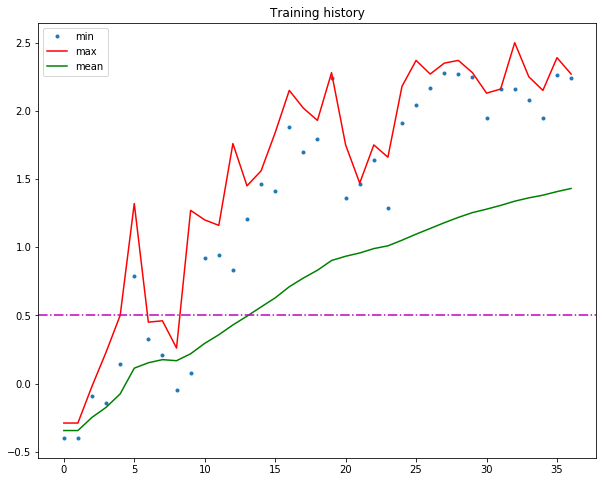

Episode 37 score mean 2.255000035278499 average on deque 1.4305405670625937
37 2.255000035278499 0.5 100


In [ ]:
scores, avgs = ddpg(actor_blue_path=actor_blue_path, actor_red_path=actor_red_path, critic_path=critic_path, max_t=1000, target_episodes=100, target_score=0.5)

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(100):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()